<a href="https://colab.research.google.com/github/NicoGangi5/Scalable_Machine_Learning_on_Big_Data_using_Apache_Spark/blob/main/W2_Ejercicio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')

In [ ]:
!pip install pyspark==2.4.5

In [ ]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

In [ ]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

In [ ]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2020-10-30 13:28:27--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2020-10-30 13:28:27--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2020-10-30 13:28:28--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ds/washing.parquet [fo

In [ ]:
df = spark.read.parquet('washing.parquet')
df

DataFrame[_id: string, _rev: string, count: bigint, flowrate: bigint, fluidlevel: string, frequency: bigint, hardness: bigint, speed: bigint, temperature: bigint, ts: bigint, voltage: bigint]

In [ ]:
df.count()

2058

In [ ]:
df.createOrReplaceTempView("washing")
spark.sql("SELECT * FROM washing").show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [ ]:
result = spark.sql("select voltage from washing where voltage is not null")

result_array = result.rdd.map(lambda row : row.voltage).sample(False,0.1).collect()

#just print the 1st 15 elements
result_array[:15]

[235, 222, 232, 222, 221, 221, 233, 232, 244, 222, 237, 237, 231, 231, 229]

In [ ]:
%matplotlib inline

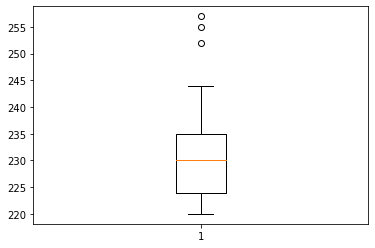

In [ ]:
import matplotlib.pyplot as plt
plt.boxplot(result_array)
plt.show()

In [ ]:
result = spark.sql("select voltage,ts from washing where voltage is not null order by ts asc")
result_rdd = result.rdd.sample(False,0.1).map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
print(result_array_ts[:15])
print(result_array_voltage[:15])

[1547808746929, 1547808752930, 1547808830981, 1547808855034, 1547808882045, 1547808891076, 1547808972147, 1547808999173, 1547809017198, 1547809032208, 1547809044214, 1547809080236, 1547809107251, 1547809122262, 1547809176311]
[222, 227, 227, 221, 234, 220, 222, 247, 250, 231, 227, 235, 220, 235, 224]


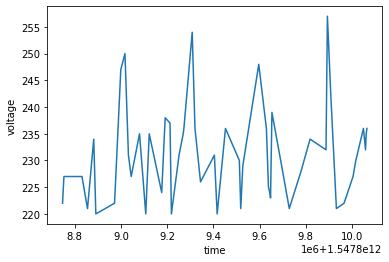

In [ ]:
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

In [ ]:
spark.sql("select min(ts),max(ts) from washing").show()

+-------------+-------------+
|      min(ts)|      max(ts)|
+-------------+-------------+
|1547808720911|1547810064867|
+-------------+-------------+



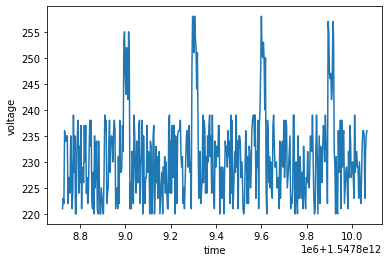

In [ ]:
result = spark.sql(
"""
select voltage,ts from washing 
    where voltage is not null and 
    ts > 1547808720911 and
    ts <= 1547810064867+3600000
    order by ts asc
""")
result_rdd = result.rdd.map(lambda row : (row.ts,row.voltage))
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

In [ ]:
result_df = spark.sql("""
select hardness,temperature,flowrate from washing
    where hardness is not null and 
    temperature is not null and 
    flowrate is not null
""")
result_rdd = result_df.rdd.sample(False,0.1).map(lambda row : (row.hardness,row.temperature,row.flowrate))
result_array_hardness = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[0]).collect()
result_array_temperature = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[1]).collect()
result_array_flowrate = result_rdd.map(lambda hardness_temperature_flowrate: hardness_temperature_flowrate[2]).collect()

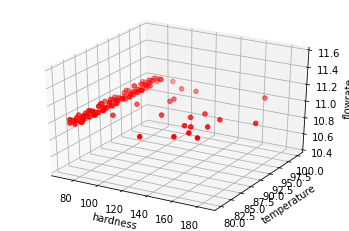

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(result_array_hardness,result_array_temperature,result_array_flowrate, c='r', marker='o')

ax.set_xlabel('hardness')
ax.set_ylabel('temperature')
ax.set_zlabel('flowrate')

plt.show()